In [1]:
%pylab inline

from astropy.io import fits
from astropy import wcs

mpl.rc('font', size=12)

Populating the interactive namespace from numpy and matplotlib


## Fiberloss Plotting

Manual plotting of data in fiberloss. Not too elegant but nice for testing outside of the fiberloss plots provided in quickspecsim.

In [2]:
def get_extents(header, data):
    w = wcs.WCS(header)

    nxy = len(data)
    xlo, ylo, xhi, yhi = w.wcs_pix2world([[0, 0], [nxy - 1, nxy - 1]], 0).flatten()
    assert xlo == ylo and xhi == yhi
    xy = np.linspace(xlo, xhi, nxy)
    xy_pad = header['CDELT1']
    return [xy[0] - xy_pad, xy[-1] + xy_pad, xy[0] - xy_pad, xy[-1] + xy_pad]

def plot_fiberloss(filename):
    f = fits.open(filename)

    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    wlen = []
    
    # Loop through all HDUs. Plot the fiber aperture and source profile.
    # Keep track of wavelengths simulated in the data file.
    for table in range(1, len(f)-1):
        header = f[table].header
    
        dtype = header['COMMENT'][-1]
        if dtype == 'Fiber aperture':
            data = f[table].data
            img = axes[1].imshow(data, extent=get_extents(header, data))
            axes[1].set(title=dtype, adjustable='box-forced', aspect='equal',
                        xlabel=r'x [$\mu$m]',
                        ylabel=r'y [$\mu$m]')
            cb = fig.colorbar(img, ax=axes[1], pad=0.01, shrink=0.7)
        if dtype == 'Source profile':
            data = f[table].data
            img = axes[0].imshow(data, extent=get_extents(header, data))
            axes[0].set(title=dtype, adjustable='box-forced', aspect='equal',
                        xlabel=r'x [$\mu$m]',
                        ylabel=r'y [$\mu$m]')
            cb = fig.colorbar(img, ax=axes[0], pad=0.01, shrink=0.7)
        
        if 'WLEN' in header:
            wl = header['WLEN']
            if wl not in wlen:
                wlen.append(wl)
    fig.tight_layout();

    ncol = 3
    nrow = len(wlen)
    
    # Loop through simulated wavelengths and plot output.
    fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 4*nrow))
    for i, wl in enumerate(wlen):
        for j in range(3):
            table = 6*i + j + 2
            header = f[table].header
            dtype = header['COMMENT'][-1]
            
            if dtype == 'Atmospheric seeing model':
                ax = axes[i][0]
                title = 'Atmos. seeing: {:g} $\\mu$m'.format(wl)
            elif dtype == 'Instrument blur model':
                ax = axes[i][1]
                title = 'Instrument blur: {:g} $\\mu$m'.format(wl)
            elif dtype == 'Convolved model':
                ax = axes[i][2]
                title = 'Convolved model: {:g} $\\mu$m'.format(wl)
            else:
                continue
                
            data = f[table].data
            img = ax.imshow(data, extent=get_extents(header, data))
            ax.set(title=title,
                   adjustable='box-forced', aspect='equal',
                   xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
            cb = fig.colorbar(img, ax=ax, pad=0.01, shrink=0.7)
            
    fig.tight_layout();

## Default Settings

This uses the default settings in specsim/data/config/desi.yaml.

Generate using

    $> quickspecsim --save-fiberloss test_fiberloss

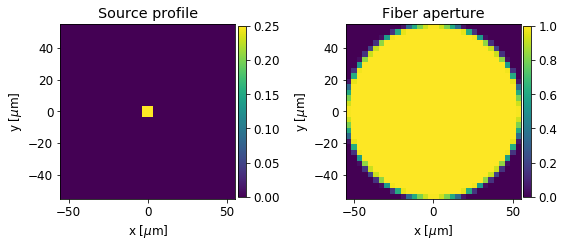

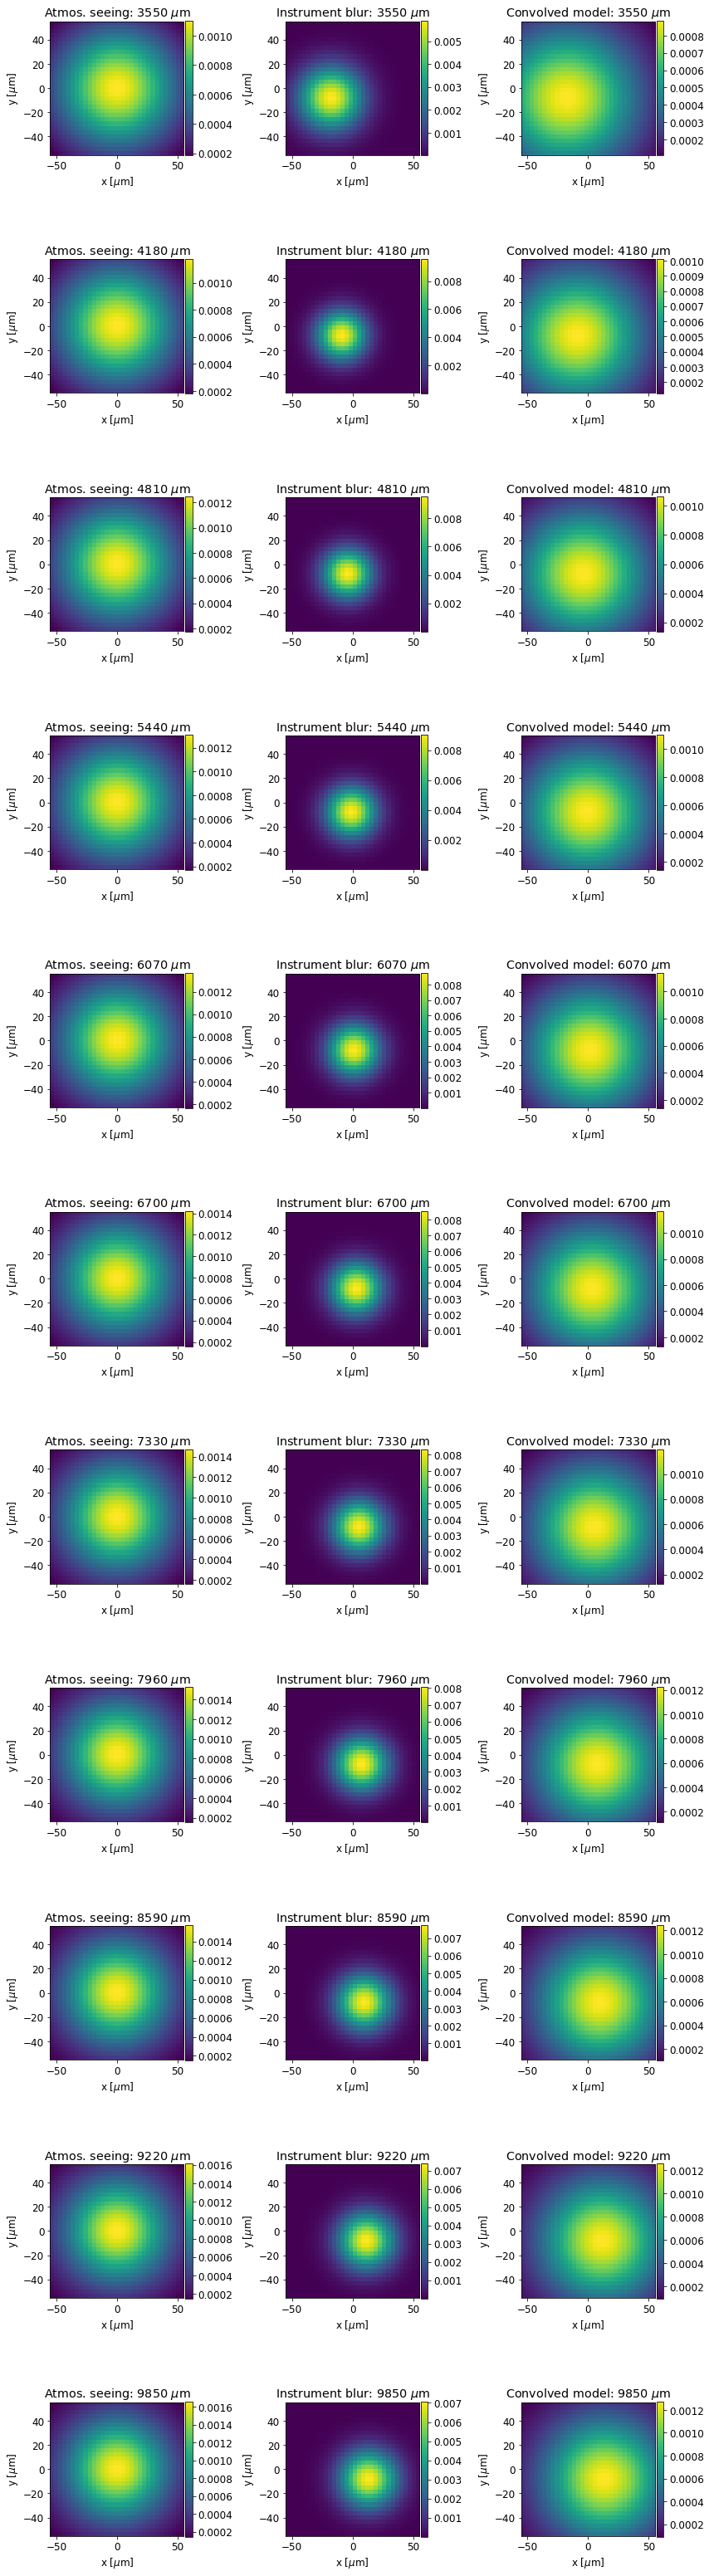

In [3]:
plot_fiberloss('test_fiberloss.fits')

## Instrument Blur Test

Turn off instrument blur, leaving all other settings alone.

This requires creating a new version of $DESIMODEL/data/throughput/DESI-0347_blur.ecsv with very small values of the RMS blur vs. wavelength and ray angle. I created a new file noblur.ecsv with 1 um values in place of the nominal RMS values.

Changing the defaults in a copy of desi.yaml this is generated with the command

    $> quickspecsim -c desi-test.yaml -o quickspec.fits --save-fiberloss test_fiberloss_noblur

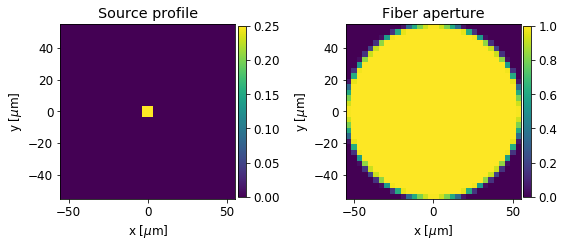

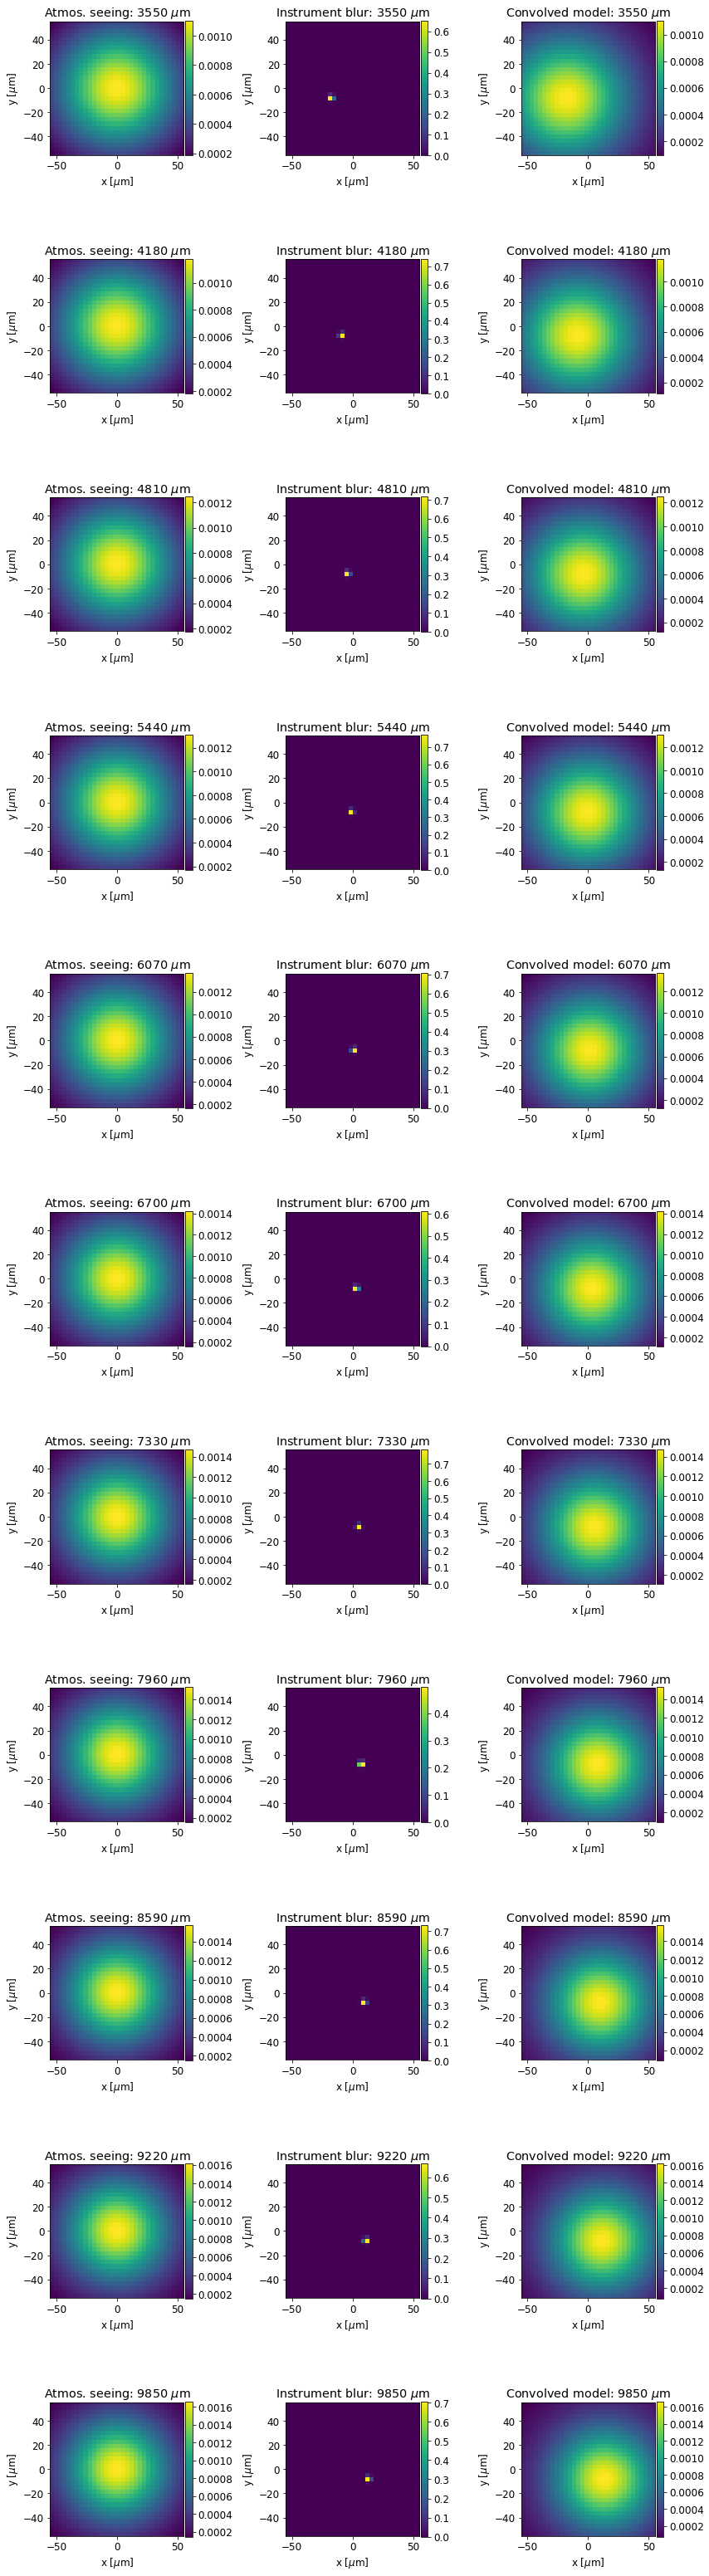

In [4]:
plot_fiberloss('test_fiberloss_noblur.fits')

## Random Offset + Seeing Test

Retain instrument PSF but remove two effects:
1. Atmospheric scattering is turned off by setting the seeing fwhm_ref to a very small value in the YAML file. For example, I used 0.05 arcsec.
2. Random offsets in the focal plane due to ADC polishing imperfections are turned off by setting the values in $DESIMODEL/data/throughput/DESI-0347_offset.ecsv to 0.

Generate with

    $> quickspecsim -c desi-test.yaml -o quickspec.fits --save-fiberloss test_fiberloss_nooffset_noseeing

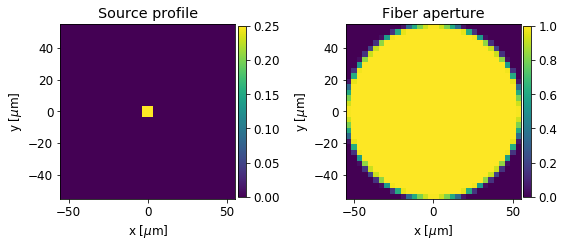

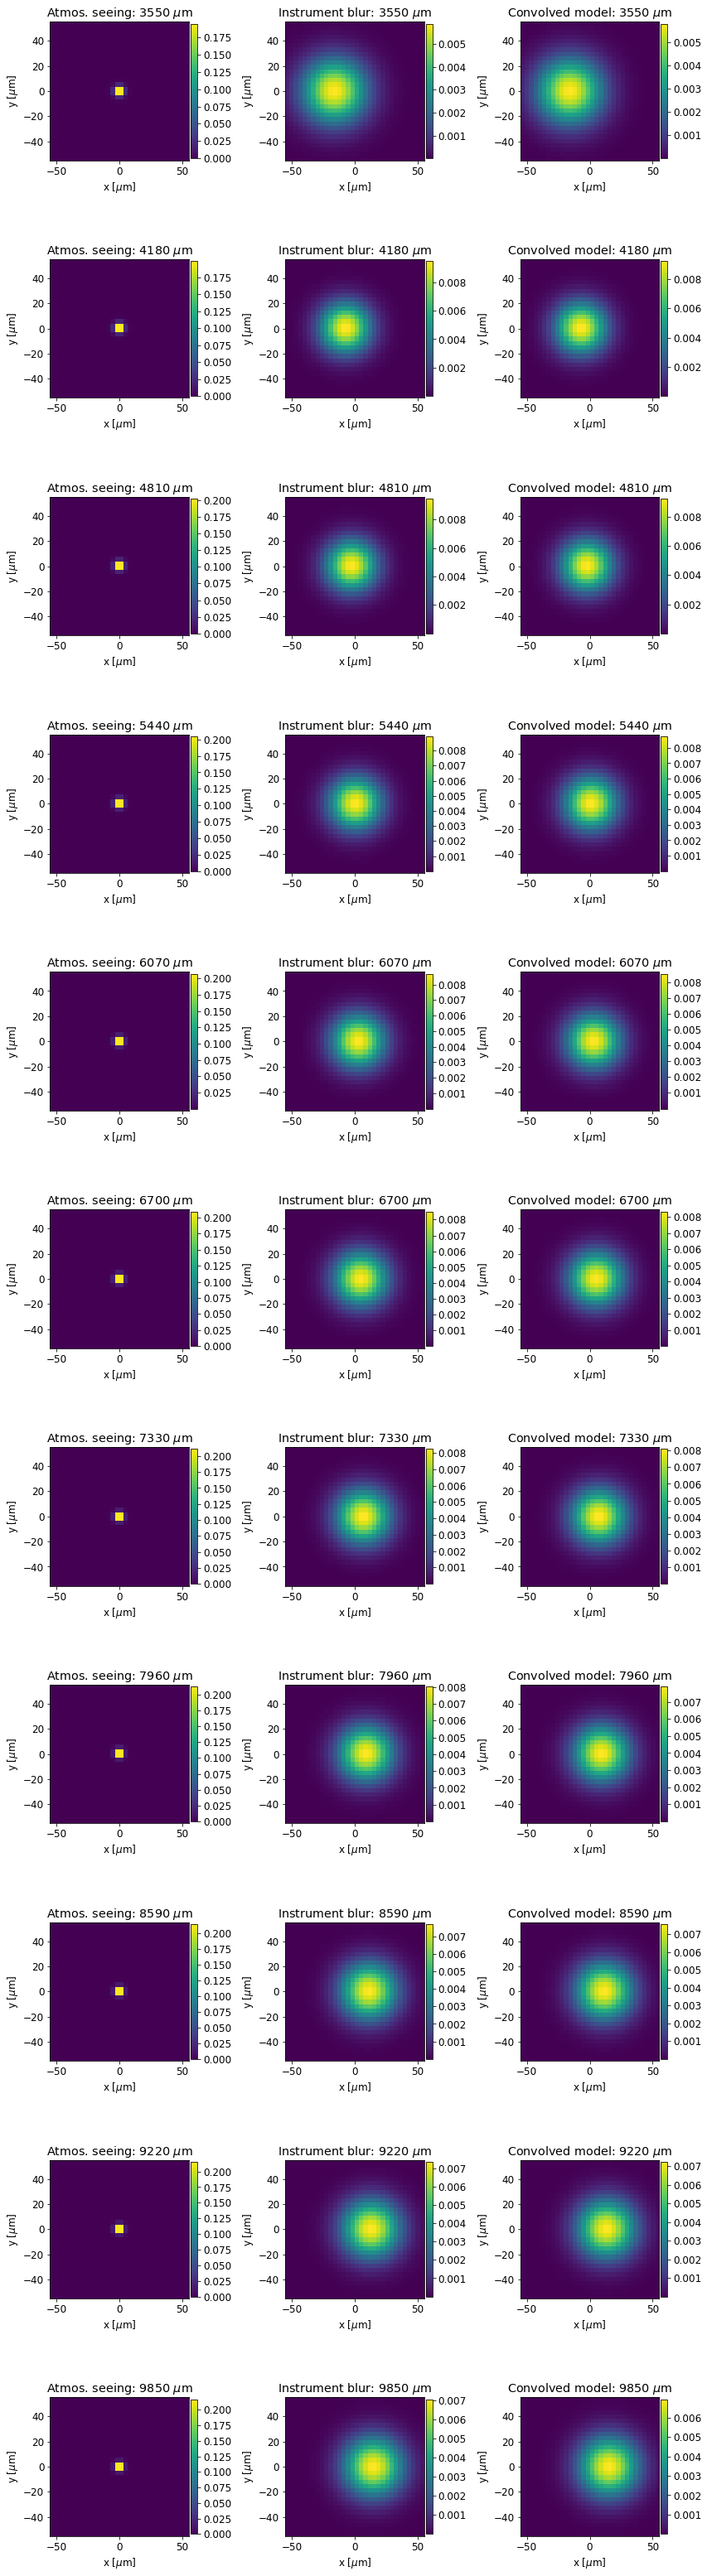

In [5]:
plot_fiberloss('test_fiberloss_nooffset_noseeing.fits')

## Instrument Blur + Random Offset + Seeing

Turn off instrument blur, random focal plane offsets, and the atmosphere as described above.

    $> quickspecsim -c desi-test.yaml -o quickspec.fits --save-fiberloss test_fiberloss_noblur_nooffset_noseeing

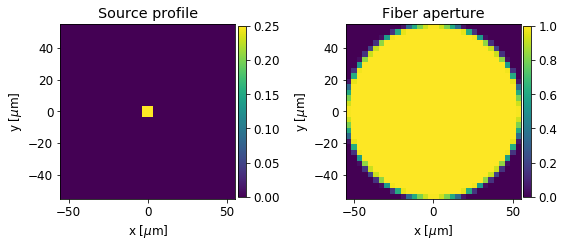

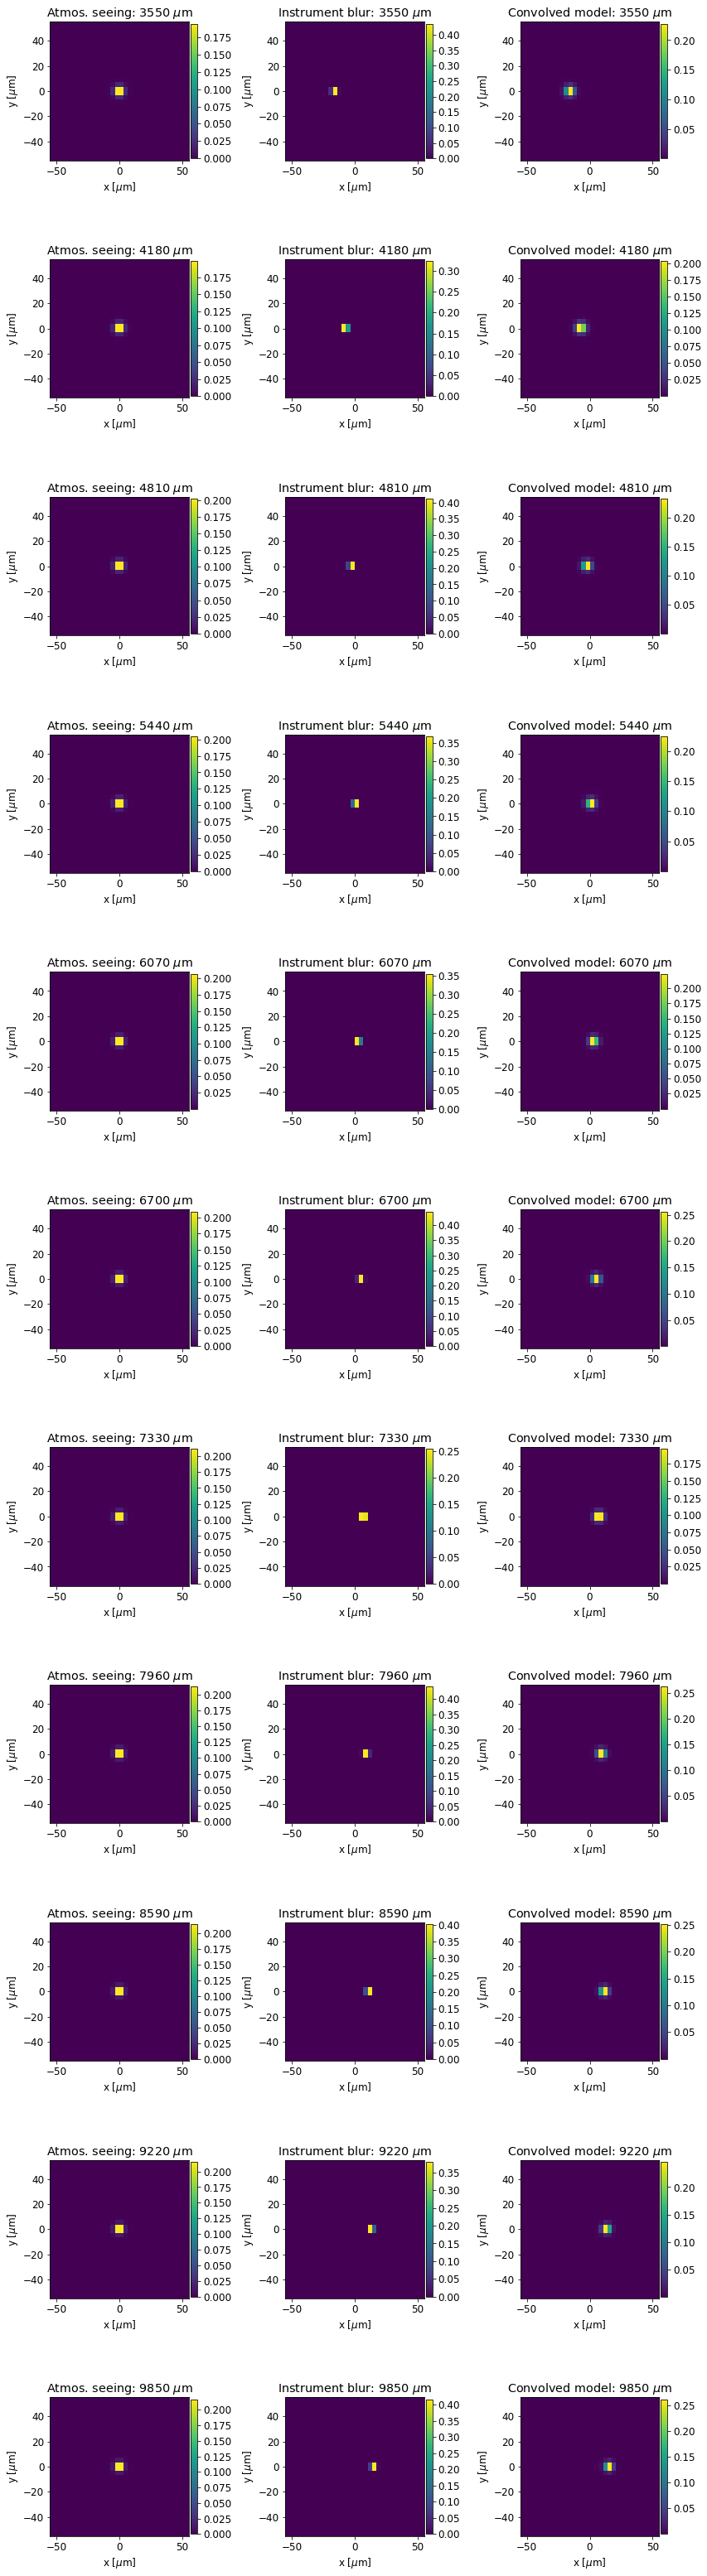

In [6]:
plot_fiberloss('test_fiberloss_noblur_nooffset_noseeing.fits')